# To do list

1 - Calcul de la grid include protein

2 - More pixels (Decaying radii) 20x20x20 --> 254x254x254x15 (memory)!!!! (Mode)

3 - Elements, atom types...

4 - Model explainability (transpose convolutional)

In [1]:
import keras
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling3D, GlobalMaxPooling3D
from keras.layers import Conv3D, MaxPool3D, Flatten, Dense, AveragePooling3D
from keras.layers import Dropout, Input, BatchNormalization
from keras.losses import categorical_crossentropy
from keras.optimizers import Adadelta
from keras.models import Model
import keras
from sklearn.model_selection import train_test_split
import numpy as np
import collections
from keras.models import model_from_yaml
import sparse
import sys
import os
import ipymol
from collections import Counter
from mpl_toolkits import mplot3d
from matplotlib import cm
from sklearn.cluster import KMeans
import plotly.express as px

Using TensorFlow backend.


In [2]:
from rdkit import Chem

RDKit WARNING: [17:04:32] Enabling RDKit 2019.09.2 jupyter extensions


In [75]:
import istarmap
import h5py
import pandas
from multiprocessing import Pool
from itertools import repeat
import prody as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import axes3d, Axes3D
import numpy as np
from tqdm import tqdm
import glob
import istarmap
from keras.models import model_from_yaml
import keras
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling3D, GlobalMaxPooling3D
from keras.layers import Conv3D, MaxPool3D, Flatten, Dense, AveragePooling3D
from keras.layers import Dropout, Input, BatchNormalization
from keras.losses import categorical_crossentropy
from keras.optimizers import Adadelta
from keras.models import Model
from sklearn.model_selection import train_test_split
import h5py
import os
from multiprocessing import Pool
from itertools import repeat
import prody as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import axes3d, Axes3D
import numpy as np
from tqdm import tqdm
import subprocess
import glob

from scipy import sparse as scipy_sparse
from rdkit.Chem import Descriptors
from itertools import count

# Functions and classes

In [76]:
def retrieve_vocabulary_from_sdf(sdfs):
    vocabulary_elements=[]; features=[]
    for sdf in tqdm(sdfs):
        supl = Chem.SDMolSupplier(sdf, removeHs=False)
        mols = [mol for mol in supl]
        getatoms = [mol.GetAtoms() for mol in mols]
        elements = set([getatoms[i][x].GetSymbol() for i in range(len(getatoms)) for x in range(len(getatoms[i]))])
        for element in elements:
            if element not in vocabulary_elements:
                vocabulary_elements.append(element)
    vocabulary_elements = {res:i for i, res in enumerate(vocabulary_elements)}
    features = len(vocabulary_elements)
    return  vocabulary_elements, features

In [77]:
class Grid(object):

    def __init__(self, center, side, resolution=None):
        self.center = center
        self.side = side
        self.resolution = resolution
        self.vertexes = self._calculate_vertexes()
    def _calculate_vertexes(self):
        center = self.center
        side = self.side

        vertexes = []
        v1 = center + [-side/2, -side/2, -side/2]
        v2 = center + [side/2, -side/2, -side/2]
        v3 = center + [-side/2, -side/2, side/2]
        v4 = center + [-side/2, side/2, -side/2]
        v5 = center + [side/2, side/2, -side/2]
        v6 = center + [side/2, -side/2, side/2]
        v7 = center + [-side/2, side/2, side/2]
        v8 = center + [side/2, side/2, side/2]
        vertexes.extend([v1, v2, v3, v4, v5, v6, v7, v8])
        return vertexes

    def calculate_pixels(self):
        print("Calculating pixels...")
        rear_back_pixel_center = self.rear_back_pixel_center = self.vertexes[6]  + np.array((self.resolution/2, -self.resolution/2, -self.resolution/2))
        self.n_pixels = n_pixels =  int(self.side / self.resolution)

    def is_point_inside(self, point):
        dist = np.linalg.norm(self.center-point)
        dist_center_diagonal = np.linalg.norm(self.center-self.vertexes[0])
        if dist < dist_center_diagonal:
            return True
        else:
            return False

    def plot(self):
        fig = plt.figure()
        ax = Axes3D(fig)
        for vertex in self.vertexes:
            vx, vy,vz = vertex.tolist()
            ax.scatter(vx, vy, vz)
        ax.set_xlabel('X')
        ax.set_ylabel('Y')
        ax.set_zlabel('Z')
        return fig.show()


In [78]:
def visualize(result, y_train, nsample, npixels=40):
    npixel = npixels
    heat_map_grids = []
    heat_elements_grids = []
    for plane in range(npixels):
        sample = result[nsample].todense()[:,:,plane].copy()
        explanation_grid = np.zeros((npixel, npixel)).copy()
        explanation_str_grid = np.empty((npixel, npixel), dtype="<U5")
        x, y, channels = sample.shape


        key_list = list(vocabulary_elements.keys()) 
        val_list = list(vocabulary_elements.values())

        for i in range(x):
            for j in range(y):
                for k in range(channels):
                    channel = sample[i, j, k]
                    if channel != 0:
                        element = key_list[val_list.index(k)]
                        explanation_grid[i, j] += 1
                        explanation_str_grid[i, j] += element
        heat_map_grids.append(explanation_grid)
        heat_elements_grids.append(explanation_str_grid)
    
    final_grid_elements = np.empty((npixel, npixel), dtype="<U5")
    final_grid = np.zeros((npixel, npixel)).copy()
    for grid_el, grid in zip(heat_elements_grids, heat_map_grids):
        final_grid_elements = np.core.defchararray.add(final_grid_elements, grid_el)
        final_grid += grid
    
    print(final_grid_elements)
    
    print("Class", np.argmax(y_train[nsample]), "Prob", y_train[nsample])
    data = final_grid
    plt.matshow(data)
    plt.show()
    

In [79]:
def extract_cnn_input(sdf_lig, sdf_rec, center_of_mass, vocabulary_elements, features, resolution, volume=True,
                     include_rec=False, just_receptor=True, just_ligands=False):

    cm = center_of_mass # finally the mean cm
    side = 20
    print("CM", cm)
    print("Build grid")
    grid2 = Grid(cm, side, resolution)
    grid2.calculate_pixels()
    
    tot_atoms = []
    tot_mols = []
    
    if include_rec:
        sdfs = [sdf_lig, sdf_rec]
    if just_receptor:
        sdfs = [sdf_rec]
    if just_ligands:
        sdfs = [sdf_lig]

    for sdf in sdfs:
        print("Load trajectory from {}".format(os.path.basename(sdf)))
        supl = Chem.SDMolSupplier(sdf, removeHs=False)
        mols = [mol for mol in supl]
        getatoms = [mol.GetAtoms() for mol in mols]
        atoms = [[getatoms[i][x].GetSymbol() for x in range(len(getatoms[i]))] for i in range(len(getatoms))]
        conf = [mol.GetConformer() for mol in mols] # for each molecule in the sdf
        num_atoms = [co.GetNumAtoms() for co in conf]
        pos = np.array([[list(co.GetAtomPosition(num)) for num in range(num_atoms[i])] for i,co in enumerate(conf)])
        # now we only take atoms of ligand in a 20A radius (supposed to be all of them if small)
        us_atoms = [[atoms[j][i] for i in range(len(atoms[j])) if np.linalg.norm(pos[j][i]- cm) <= side ] for j in range(len(atoms))]
        tot_atoms += us_atoms
        tot_mols += mols
    print("Filling grid with atom info")
    atoms_all_mols, dict_at_pos, core_atoms, belonging = fill_grid_with_atoms(grid2, tot_mols, tot_atoms, cm, vocabulary_elements, features, side=side, 
                                                       volume=volume, include_rec=include_rec, just_receptor=just_receptor, 
                                                       just_ligands=just_ligands)
    return [atoms_all_mols, dict_at_pos, core_atoms, belonging, sdf_lig, sdf_rec]


In [88]:
def fill_grid_with_atoms(grid2, mols, atoms, cm, vocabulary_elements, features, side, include_rec=False, just_receptor=True, just_ligands=False, volume=True):

    at_all_mols = []
    dict_at_pos = {}
    core_atoms = {}
    belonging = {}
    if include_rec:
        mols = [mol for mol in mols[0]+mols[1]]
        atoms = [atom for atom in atoms[0]+atoms[1]]
    print(len(mols), len(atoms))
    for mol in tqdm(range(len(mols))):
            sparse_matrix_dict = {}
            atoms_per_pixel = np.zeros((grid2.n_pixels, grid2.n_pixels, grid2.n_pixels, features),  dtype=int)
            molec = mols[mol]
            conf = molec.GetConformer() # for each molecule in the sdf
            num_atoms = conf.GetNumAtoms()
            coords_mol = np.array(list([conf.GetAtomPosition(num) for num in range(num_atoms)]))
            dict_at_pos[mol] = {}
            core_atoms[mol] = {}
            belonging[mol] = {}
            for atom in np.unique(atoms[mol]):
                dict_at_pos[mol][atom] = []
            for tt, atom in enumerate(range(len(atoms[mol]))):
                element = atoms[mol][atom]
                coords = coords_mol[atom]
                #assert grid2.is_point_inside(coords), coords
                ixs = np.array([int(abs((x/grid2.resolution))) for x in np.array(np.array(coords) - np.array(grid2.rear_back_pixel_center))])
                #computing volumes
                if volume:
                    idxs = volume_occupancy(grid2.resolution, element, ixs, vocabulary_elements, side)
                else:
                    idxs = [ixs]
                belonging[mol][element] = idxs
                if len(dict_at_pos[mol][element]) == 0:
                    dict_at_pos[mol][element] = idxs
                    core_atoms[mol][element] = [ixs]
                else:
                    try:
                        dict_at_pos[mol][element] = np.concatenate((dict_at_pos[mol][element], idxs))
                        core_atoms[mol][element] =  np.concatenate((core_atoms[mol][element], [ixs]))
                    except ValueError:
                        print('ValueError', idxs)
                for idx in idxs:
                    try:
                        atoms_per_pixel[idx[0]][idx[1]][idx[2]]
                    except IndexError:
                        print('Cant assign atoms per pixel', idx)

                    pixel = atoms_per_pixel[idx[0]][idx[1]][idx[2]].copy()
                    try:
                        value =  pixel[vocabulary_elements[element]] + 1
                        pixel[vocabulary_elements[element]] = value
                    except TypeError:
                        value =  1
                        pixel[vocabulary_elements[element]] = value

                    atoms_per_pixel[idx[0], idx[1], idx[2]] = pixel
                    
                    index = (idx[0], idx[1], idx[2], vocabulary_elements[element])
                    sparse_matrix_dict[index]=value

            sparse_matrix_dict[(grid2.n_pixels-1,grid2.n_pixels-1,grid2.n_pixels-1,features-1)]=0
            try:
                x = sparse.COO(sparse_matrix_dict)
                at_all_mols.append(x)

            except ValueError:
                print('Probably negative indices detected')
                break
    print('moleculas', len(mols), len(core_atoms))
    return at_all_mols, dict_at_pos, core_atoms, belonging


In [89]:
def radius_assignation(folder, filename='radius.txt', costum=True):
    
    data = pandas.read_csv(os.path.join(folder, filename))[7:]
    radius = {}
    for i in data['Atomic']:
        if costum:
            if len(i.split()) == 7:
                radius[i.split()[1]] = float(i.split()[5])
            else:
                radius[i.split()[1]] = 1            
        else:
            radius[i.split()[1]] = 1
    return radius

In [82]:
def volume_occupancy(resolution, element, pixel, vocabulary_elements, side):
    
    minindx = 0 #minimum index
    maxindx = side/resolution #maximum index
    radii = radius_assignation(folder=folder)
    radius = radii[element]
    #sphere equation (x-a)**2 + (y-a)**2 + (z-a)**2 = r**2
    maxrange = int(max((radius-resolution)/resolution, 0))
    rangex = list(range(pixel[0]-maxrange, pixel[0] + maxrange+1))
    rangey = list(range(pixel[1]-maxrange, pixel[1] + maxrange+1))
    rangez = list(range(pixel[2]-maxrange, pixel[2] + maxrange+1))
    #computing activated pixels
    usefuls = []
    
    for i in range(len(rangex)):
        for j in range(len(rangey)):
            for k in range(len(rangez)):
                if (i*resolution)**2 + (j*resolution)**2 + (k*resolution)**2 <= radius**2:
                    usefuls += [[a,b,c] for a in [-i,i] for b in [-j,j] for c in [-k,k]]
                else:
                    break
    Vol_pixel = resolution**3
    Vol_element = 4/3*np.pi*radius**3
    usefuls = np.unique(usefuls, axis=0)
    movedp = [pixel + idx for idx in usefuls]
    moved = [ids for ids in movedp if not ids[ids<minindx].any() if not ids[ids>=maxindx].any()]
    if len(moved) == 0:
        print('Ep! atom outside box!')
    Aprox_vol = Vol_pixel*len(moved)
    Error_vol = (abs(Aprox_vol-Vol_element)/Vol_element)*100
   # print(element, '--->Real vol', Vol_element, 'Calculate vol', Aprox_vol, 'Error vol (%)', Error_vol)
    return moved

In [83]:
def labels_to_plot(Xt, folder, elem_core, nsample, vocabulary_elements):
    
    labels = []; pos = []; labels_core = []; pos_core = [] ; size = []
    x,y,z,l = Xt.shape
    for i in tqdm(range(x)):
        for j in range(y):
            for k in range(z):
                label = np.where(Xt[i][j][k] == 1)[0]
                if label.size > 0:   
                    for la in label:
                        labels.append(la)
                        pos.append([i,j,k])
    
    #now computing core positions       
    radius = radius_assignation(folder, filename='radius.txt', costum=True)
    for elem in elem_core.keys():
        for i,j in elem_core[elem]:
            if i == nsample: 
                for pp in j:
                    size.append(radius[elem]/resolution)
                    labels_core.append(vocabulary_elements[elem])
                    pos_core.append(pp)
    
    return labels, np.array(pos), labels_core, np.array(pos_core), size

In [84]:
def plot_3d(labels_core, labels, pos_core, pos, size, vocabulary_elements, centers=True):
    #first we group pixels of same atom to easy visualization
    if centers:
        labels = labels_core
        pos = pos_core
    else:
        size = [0.1 for i in labels]
    fig, ax = plt.subplots()
    ax = plt.axes(projection='3d')
    used = []
    for i in tqdm(range(len(labels))):
        if labels[i] == vocabulary_elements['H']:
            ax.scatter(pos[i,0], pos[i,1], pos[i,2], c = 'darkorange', cmap='viridis', s=size[i]*200, linewidth=0.5, label ='H')
            used.append('H')
        if labels[i] == vocabulary_elements['C']:
            ax.scatter(pos[i,0], pos[i,1], pos[i,2], c = 'black', cmap='viridis', s=size[i]*200, linewidth=0.5, label = 'C')
            used.append('C')
        if labels[i] == vocabulary_elements['N']:
            ax.scatter(pos[i,0], pos[i,1], pos[i,2], c = 'cyan', cmap='viridis', s=size[i]*200,  linewidth=0.5, label = 'N')  
            used.append('N')
        if labels[i] == vocabulary_elements['O']:
            ax.scatter(pos[i,0], pos[i,1], pos[i,2], c = 'red', cmap='viridis', s=size[i]*200,  linewidth=0.5, label = 'O')
            used.append('O')
        if labels[i] == vocabulary_elements['Br']:
            ax.scatter(pos[i,0], pos[i,1], pos[i,2], c = 'saddlebrown', cmap='viridis', s=size[i]*200,  linewidth=0.5, label = 'Br')
            used.append('Br')
        if labels[i] == vocabulary_elements['Cl']:
            ax.scatter(pos[i,0], pos[i,1], pos[i,2], c = 'green', cmap='viridis', s=size[i]*200,  linewidth=0.5, label = 'Cl')
            used.append('Cl')
        if labels[i] == vocabulary_elements['F']:
            ax.scatter(pos[i,0], pos[i,1], pos[i,2], c = 'greenyellow', cmap='viridis',  s=size[i]*200, linewidth=0.5, label='F')
            used.append('F')
        if labels[i] == vocabulary_elements['I']:
            ax.scatter(pos[i,0], pos[i,1], pos[i,2], c = 'darkviolet', cmap='viridis', s=size[i]*200,  linewidth=0.5, label='I')
            used.append('I')
        if labels[i] == vocabulary_elements['S']:
            ax.scatter(pos[i,0], pos[i,1], pos[i,2], c = 'yellow', cmap='viridis', s=size[i]*200,  linewidth=0.5, label='S')
            used.append('S')
        if labels[i] == vocabulary_elements['P']:
            ax.scatter(pos[i,0], pos[i,1], pos[i,2], c = 'oranged', cmap='viridis', s=size[i]*200,  linewidth=0.5, label='P')
            used.append('P')
    used = np.unique(used)
    handles, labels = plt.gca().get_legend_handles_labels()
    by_label = dict(zip(labels, handles))
    plt.legend(by_label.values(), by_label.keys())
    

In [85]:
def pixels_importance(model, X, X_rec, y_train, nsample):
    
    print('Analysis on pixels...')
    print('Len x', len(X))
    x,y,z,l = X[0].shape
    print(x,y,z,l)
    params_test = {'dim': (x,y,z),
              'batch_size': 1,
              'n_classes': 2,
              'n_channels': l,
              'shuffle': False,
              'tofit': True}

    print('Preparing generator')
    test_generator = DataGenerator([nsample], labels=y_train, X=X, **params_test)
    pred_baseline = model.predict_generator(test_generator)[0]
    print('pred baseline', pred_baseline)
    true_label = y_train[nsample]
    print('true label', true_label)
    label = np.argmax(pred_baseline)

    nsamples = len(X)
    x,y,z,l = X[0].shape
    blank_pixel = np.zeros(l)

    importance_pixel = np.zeros((x,y,z))
    pos = []
    old_X = X.copy()
    old_X_rec = X_rec.copy()
    ligand_contributions = []
    for coordx in tqdm(range(x)):
        for coordy in range(y):
            for coordz in range(z):
                new_X_train = old_X[nsample].todense()
                X_rec = old_X_rec[nsample].todense()
                if 1 in new_X_train[coordx,coordy,coordz]:
                    if X_rec[coordx,coordy,coordz] != new_X_train[coordx,coordy,coordz]:
                        ligand_contributions.append([coordx,coordy,coordz])
                    new_X_train[coordx, coordy, coordz] = blank_pixel
                    new_X_sparse = [sparse.COO(new_X_train)]
                    test_generator = DataGenerator([0], labels=y_train, X=new_X_sparse, **params_test)
                    pred =  model.predict_generator(test_generator)[0]
                    if true_label[label] == 1:
                        importance_single_pixel = pred[1] - pred_baseline[1]
                    else:
                        importance_single_pixel = pred_baseline[1] - pred[1]
                    pos.append([coordx, coordy, coordz, importance_single_pixel])
                else:
                    importance_single_pixel=0
                importance_pixel[coordx,coordy,coordz] = importance_single_pixel

    print('ligand', len(ligand_contributions))
    print('rec + ligand', len(pos))
    
    return np.array(pos), ligand_contributions

In [86]:
def visualize_receptor(result):
    X = []; Y = []; sdfs = []; total_names=[]; total_indices=[];
    tot = 0
    ii = 0
    for clust, _ , sdf_lig, sdf_rec in tqdm(result): # for each cluster
        print('sdf', sdf_rec)
        for i, x in tqdm(enumerate(clust)): # for each mol in the cluster
            sdfs.append(sdf)
            total_indices.append(i)
            X.append(x)

    n = len(X)
    x,y,z,l = X[0].shape
    print(n,x,y,z,l)
    
    #now prepare sample to visualize
    nsample = 0
    X0 = X[nsample].todense()
    labels, pos = labels_to_plot(X0)
    #print("molecule name", total_names[nsample])
    print("file", sdfs_rec[nsample])
    print("Index inside file", total_indices[nsample])
    %matplotlib notebook
    plot_3d(labels, pos, vocabulary_elements)
    return

# Extract features

In [90]:
resolution = 0.5
folder = '/Users/modeorozco/NBD/dani_structural'
folder_topass = '/Users/modeorozco/NBD/dani_structural/topass'
just_rec = False
just_ligands = True
volume = True
include_rec = False

# loading
vocabulary_elements = np.load(os.path.join(folder_topass, 'vocabulary.npy'), allow_pickle=True).item()
features = np.load(os.path.join(folder_topass,'features.npy')).item()
sdfs_lig = np.load(os.path.join(folder_topass,'sdfs_lig.npy'))
sdfs_rec = np.load(os.path.join(folder,'sdfs_rec.npy'))

sdfs_lig = [os.path.join(folder, os.path.basename(name)) for name in sdfs_lig]
sdfs_rec = [os.path.join(folder, os.path.basename(name)) for name in sdfs_rec]

if include_rec:
    sdfs = np.concatenate((sdfs_lig, sdfs_rec))
if just_rec:
    sdfs = sdfs_rec
if just_ligands:
    sdfs = sdfs_lig
    
#Create COM
coms = []
for sdf in tqdm(sdfs):
    supl = Chem.SDMolSupplier(sdf, removeHs=False)
    mols = [mol for mol in supl]
    getatoms = [mol.GetAtoms() for mol in mols]
    atoms = [[getatoms[i][x].GetSymbol() for x in range(len(getatoms[i]))] for i in range(len(getatoms))]
    conf = [mol.GetConformer() for mol in mols] # for each molecule in the sdf
    num_atoms = [co.GetNumAtoms() for co in conf]
    pos = np.array([[list(co.GetAtomPosition(num)) for num in range(num_atoms[i])] for i,co in enumerate(conf)])
    masses = np.array([Descriptors.MolWt(mol) for mol in mols]) #masses of all the ligands
    centers_of_mass = [np.sum([np.array(getatoms[i][j].GetMass()) * pos[i][j] for j in range(num_atoms[i])], axis=0)/masses[i] for i in range(len(masses))]
    coms.extend(centers_of_mass)
center_grid = np.mean(np.array(coms), axis=0)

assert center_grid.shape[0] == 3

result = [extract_cnn_input(sdf_lig, sdf_rec, center_grid, vocabulary_elements, features, resolution, volume=volume,
          include_rec=include_rec, just_receptor=just_rec, just_ligands=just_ligands) for sdf_lig, sdf_rec in zip(sdfs_lig, sdfs_rec)]

100%|██████████| 10/10 [00:03<00:00,  2.78it/s]


CM [44.87630491 46.39778337 38.89829593]
Build grid
Calculating pixels...
Load trajectory from input__cluster.c0__dock_lib.sdf


  1%|          | 1/151 [00:00<00:20,  7.36it/s]

Filling grid with atom info
151 151


  0%|          | 0/80 [00:00<?, ?it/s]

moleculas 151 151
CM [44.87630491 46.39778337 38.89829593]
Build grid
Calculating pixels...
Load trajectory from input__cluster.c1__dock_lib.sdf
Filling grid with atom info
80 80


100%|██████████| 80/80 [00:09<00:00,  8.84it/s]


moleculas 80 80
CM [44.87630491 46.39778337 38.89829593]
Build grid
Calculating pixels...
Load trajectory from input__cluster.c2__dock_lib.sdf


  1%|          | 1/181 [00:00<00:36,  4.91it/s]

Filling grid with atom info
181 181


  0%|          | 0/57 [00:00<?, ?it/s]

moleculas 181 181
CM [44.87630491 46.39778337 38.89829593]
Build grid
Calculating pixels...
Load trajectory from input__cluster.c3__dock_lib.sdf
Filling grid with atom info
57 57


100%|██████████| 57/57 [00:06<00:00,  8.96it/s]


moleculas 57 57
CM [44.87630491 46.39778337 38.89829593]
Build grid
Calculating pixels...
Load trajectory from input__cluster.c4__dock_lib.sdf


  1%|          | 1/195 [00:00<00:31,  6.07it/s]

Filling grid with atom info
195 195


100%|██████████| 195/195 [00:27<00:00,  7.06it/s]


moleculas 195 195
CM [44.87630491 46.39778337 38.89829593]
Build grid
Calculating pixels...
Load trajectory from input__cluster.c5__dock_lib.sdf


  1%|          | 1/158 [00:00<00:30,  5.21it/s]

Filling grid with atom info
158 158


100%|██████████| 158/158 [00:22<00:00,  7.14it/s]


moleculas 158 158
CM [44.87630491 46.39778337 38.89829593]
Build grid
Calculating pixels...
Load trajectory from input__cluster.c6__dock_lib.sdf


  1%|          | 1/160 [00:00<00:28,  5.50it/s]

Filling grid with atom info
160 160


 37%|███▋      | 59/160 [00:09<00:15,  6.56it/s]

Ep! atom outside box!
ValueError []
Ep! atom outside box!
ValueError []
Ep! atom outside box!
ValueError []
Ep! atom outside box!
ValueError []


100%|██████████| 160/160 [00:22<00:00,  7.19it/s]


moleculas 160 160
CM [44.87630491 46.39778337 38.89829593]
Build grid
Calculating pixels...
Load trajectory from input__cluster.c7__dock_lib.sdf


  0%|          | 0/123 [00:00<?, ?it/s]

Filling grid with atom info
123 123


100%|██████████| 123/123 [00:16<00:00,  7.26it/s]


moleculas 123 123
CM [44.87630491 46.39778337 38.89829593]
Build grid
Calculating pixels...
Load trajectory from input__cluster.c8__dock_lib.sdf


  1%|          | 1/163 [00:00<00:31,  5.09it/s]

Filling grid with atom info
163 163


100%|██████████| 163/163 [00:24<00:00,  6.68it/s]


moleculas 163 163
CM [44.87630491 46.39778337 38.89829593]
Build grid
Calculating pixels...
Load trajectory from input__cluster.c9__dock_lib.sdf


  1%|          | 1/146 [00:00<00:26,  5.44it/s]

Filling grid with atom info
146 146


100%|██████████| 146/146 [00:19<00:00,  7.32it/s]

moleculas 146 146


In [101]:
ii = 0 
for i in range(len(result)):
    ii += len(result[i][1].keys())
ii

1414

From result: atoms_all_mols, dict_at_pos, core_atoms, belonging, sdf_lig, sdf_rec

If just receptor run this

In [102]:
#visualize_receptor(result)

In [103]:
actives = os.path.join(folder, "actives.sdf")
inactives = os.path.join(folder, "decoys_final.sdf")
with open(actives, "r") as f:
    data = f.readlines()
    ids = np.array([i+1 for i, j in zip(count(), data) if j == '$$$$\n'])
    ids[-1] = 0 # first line contains a name, but not the last
    acts = [data[idx].split('\n')[0] for idx in ids]
with open(inactives, "r") as f:
    data = f.readlines()
    ids = np.array([i+1 for i, j in zip(count(), data) if j == '$$$$\n'])
    ids[-1] = 0
    inacts = [data[idx].split('\n')[0] for idx in ids]


In [105]:
aa = []
for _, _ , atoms, _ , _ ,_ in tqdm(result):
    aa+=atoms
len(aa)

100%|██████████| 10/10 [00:00<00:00, 21925.27it/s]


1414

In [157]:
X = []; Y = []; sdfs = []; total_names=[]; total_indices=[]; cores = []; belongings = []
tot = 0

for clust, _ , atoms, bel, sdf_lig, _ in tqdm(result): # for each cluster
    sdfs.append(sdf_lig)
    cores += atoms
    belongings += [bel]
    with open(sdf_lig, "r") as f:
        data = f.readlines()
        ids = [i+1 for i, j in zip(count(), data) if j == '$$$$\n']
        del ids[-1]
        ids.insert(0, 0) #Insert first line as always have a molecule name
        ids = np.array(ids)
        names_lig = [data[idx].split('\n')[0] for idx in ids]
    
        if "clust3" in sdf_lig:
            assert names[0] == "CHEMBL115876"
            assert names[-1] == "CHEMBL255389"
            assert names[3] == "ZINC36928916"
    for i, x in tqdm(enumerate(clust)): # for each mol in the cluster
        total_indices.append(i)
        if names_lig[i] in acts:
            Y.append(1)
            X.append(x)
            ii += 1
        elif names_lig[i] in inacts:
            Y.append(0)
            X.append(x)
            ii += 1
        elif names_lig[i] not in acts and names_lig[i] not in inacts:
            Y.append(1)
            X.append(x)
            ii += 1;

    total_names.extend(names_lig)
    print(sdf_lig, ii, len(cores), len(names_lig), len(total_indices), len(total_names))

    y_train = keras.utils.to_categorical(Y, 2)

n = len(X)
x,y,z,l = X[0].shape
print('train shape', y_train.shape, len(cores), n,x,y,z,l)


  0%|          | 0/10 [00:00<?, ?it/s]

151it [00:00, 25166.49it/s]


80it [00:00, 22258.33it/s]


181it [00:00, 30503.42it/s]


57it [00:00, 29873.21it/s]


195it [00:00, 23134.93it/s]


158it [00:00, 18834.73it/s]


160it [00:00, 22661.96it/s]

 70%|███████   | 7/10 [00:00<00:00, 66.86it/s]

123it [00:00, 25916.78it/s]


163it [00:00, 28113.81it/s]


146it [00:00, 27137.97it/s]
100%|██████████| 10/10 [00:00<00:00, 65.46it/s]

/Users/modeorozco/NBD/dani_structural/input__cluster.c0__dock_lib.sdf 10049 151 151 151 151
/Users/modeorozco/NBD/dani_structural/input__cluster.c1__dock_lib.sdf 10129 231 80 231 231
/Users/modeorozco/NBD/dani_structural/input__cluster.c2__dock_lib.sdf 10310 412 181 412 412
/Users/modeorozco/NBD/dani_structural/input__cluster.c3__dock_lib.sdf 10367 469 57 469 469
/Users/modeorozco/NBD/dani_structural/input__cluster.c4__dock_lib.sdf 10562 664 195 664 664
/Users/modeorozco/NBD/dani_structural/input__cluster.c5__dock_lib.sdf 10720 822 158 822 822
/Users/modeorozco/NBD/dani_structural/input__cluster.c6__dock_lib.sdf 10880 982 160 982 982
/Users/modeorozco/NBD/dani_structural/input__cluster.c7__dock_lib.sdf 11003 1105 123 1105 1105
/Users/modeorozco/NBD/dani_structural/input__cluster.c8__dock_lib.sdf 11166 1268 163 1268 1268
/Users/modeorozco/NBD/dani_structural/input__cluster.c9__dock_lib.sdf 11312 1414 146 1414 1414
train shape (1414, 2) 1414 1414 40 40 40 10


In [ ]:
class DataGenerator(keras.utils.Sequence):
    'Generates data for Keras'
    def __init__(self, list_IDs, labels, X, batch_size=32, dim=(32,32,32), n_channels=1,
                 n_classes=10, shuffle=True, tofit=True):
        self.dim = dim
        self.batch_size = batch_size
        self.y = labels
        self.X = X
        self.tofit = tofit
        self.list_IDs = list_IDs
        self.n_channels = n_channels
        self.n_classes = n_classes
        self.shuffle = shuffle
        self.on_epoch_end()
        self.i = 0

    def __len__(self):
        if self.tofit:
            return int(np.floor(len(self.list_IDs) / self.batch_size))
        else:
            return int(np.floor(len(self.list_IDs) / self.batch_size)) + 1

    def __getitem__(self, index):
        # Generate indexes of the batch
        #print(index)
        indexes = self.indexes[index * self.batch_size:(index + 1) * self.batch_size]
        self.i += len(indexes)
        print(self.i, len(self.indexes))
        list_IDs_temp = [self.list_IDs[k] for k in indexes]
        X = [self.X[k].todense() for k in list_IDs_temp]
        y = [self.y[k, :] for k in list_IDs_temp]
        return np.array(X), np.array(y)


    def on_epoch_end(self):
        """Updates indexes after each epoch
        """
        self.indexes = np.arange(len(self.list_IDs))
        if self.shuffle == True:
            np.random.shuffle(self.indexes)

visualize ligand

# Loading trained model in cluster

In [22]:
import random
train_idx = np.random.choice(list(range(len(y_train))), size=int(0.8*len(y_train)), replace=False)
val_idx = [idx for idx in list(range(len(y_train))) if idx not in train_idx]
test_idx = list(range(len(y_train)))
len(train_idx), len(val_idx), len(test_idx)

(1131, 283, 1414)

In [23]:
params_test = {'dim': (x,y,z),
          'batch_size': l,
          'n_classes': 2,
          'n_channels': l,
          'shuffle': False,
          'tofit': False}

In [24]:
params_validation = {'dim': (x,y,z),
          'batch_size': l,
          'n_classes': 2,
          'n_channels': l,
          'shuffle': False,
          'tofit': True}

In [25]:
from keras.models import load_model as keras_load_model
import tensorflow as tf
tf.random.set_seed(0)
print('Loading model...')
loaded_model = keras_load_model(os.path.join(folder_topass,'all_model.h5'))
loaded_model.compile(loss='binary_crossentropy', optimizer=Adadelta(lr=0.1), metrics=['accuracy'])

Loading model...


In [26]:
test_generator = DataGenerator(test_idx, labels=y_train, X=X, **params_test)

In [27]:
ac1 = loaded_model.evaluate_generator(generator=test_generator)

10 1414
20 1414
30 1414
40 1414
50 1414
60 1414
70 1414
80 1414
90 1414
100 1414
110 1414
120 1414
130 1414
140 1414
150 1414
160 1414
170 1414
180 1414
190 1414
200 1414
210 1414
220 1414
230 1414
240 1414
250 1414
260 1414
270 1414
280 1414
290 1414
300 1414
310 1414
320 1414
330 1414
340 1414
350 1414
360 1414
370 1414
380 1414
390 1414
400 1414
410 1414
420 1414
430 1414
440 1414
450 1414
460 1414
470 1414
480 1414
490 1414
500 1414
510 1414
520 1414
530 1414
540 1414
550 1414
560 1414
570 1414
580 1414
590 1414
600 1414
610 1414
620 1414
630 1414
640 1414
650 1414
660 1414
670 1414
680 1414
690 1414
700 1414
710 1414
720 1414
730 1414
740 1414
750 1414
760 1414
770 1414
780 1414
790 1414
800 1414
810 1414
820 1414
830 1414
840 1414
850 1414
860 1414
870 1414
880 1414
890 1414
900 1414
910 1414
920 1414
930 1414
940 1414
950 1414
960 1414
970 1414
980 1414
990 1414
1000 1414
1010 1414
1020 1414
1030 1414
1040 1414
1050 1414
1060 1414
1070 1414
1080 1414
1090 1414
1100 1414
1110 141

In [28]:
ac1

[0.2601372003555298, 0.8585572838783264]

In [29]:
pred_generator2 = DataGenerator(test_idx, labels=y_train, X=X, **params_test)

In [30]:
preds2 = loaded_model.predict_generator(pred_generator2)

10 1414
20 1414
30 1414
40 1414
50 1414
60 1414
70 1414
80 1414
90 1414
100 1414
110 1414
120 1414
130 1414
140 1414
150 1414
160 1414
170 1414
180 1414
190 1414
200 1414
210 1414
220 1414
230 1414
240 1414
250 1414
260 1414
270 1414
280 1414
290 1414
300 1414
310 1414
320 1414
330 1414
340 1414
350 1414
360 1414
370 1414
380 1414
390 1414
400 1414
410 1414
420 1414
430 1414
440 1414
450 1414
460 1414
470 1414
480 1414
490 1414
500 1414
510 1414
520 1414
530 1414
540 1414
550 1414
560 1414
570 1414
580 1414
590 1414
600 1414
610 1414
620 1414
630 1414
640 1414
650 1414
660 1414
670 1414
680 1414
690 1414
700 1414
710 1414
720 1414
730 1414
740 1414
750 1414
760 1414
770 1414
780 1414
790 1414
800 1414
810 1414
820 1414
830 1414
840 1414
850 1414
860 1414
870 1414
880 1414
890 1414
900 1414
910 1414
920 1414
930 1414
940 1414
950 1414
960 1414
970 1414
980 1414
990 1414
1000 1414
1010 1414
1020 1414
1030 1414
1040 1414
1050 1414
1060 1414
1070 1414
1080 1414
1090 1414
1100 1414
1110 141

In [31]:
from sklearn.metrics import classification_report, confusion_matrix
Y = [np.argmax(y) for y in y_train]
print('conf matrix', confusion_matrix(Y, [np.argmax(pred) for pred in preds2]))

conf matrix [[603   8]
 [192 611]]


# Sensitivity analysis

## All elements

Count the average of how many times an atom show up in the structure

In [32]:
dict_atoms_pos = []
dict_core_pos = []
for _, d , co, _, _ in result:
    dict_atoms_pos.append(d)
    dict_core_pos.append(co)

Assigning positions of each element in vocabulary

In [33]:
importances_dict = vocabulary_elements.copy()
elem_dict = {}

for element in tqdm(importances_dict.keys()):
    sites = []
    totmol = 0
    for clust in range(len(dict_atoms_pos)): #for each cluster
        nums = dict_atoms_pos[clust].keys() #molecules
        for num in nums: #for each molecule
            elems = dict_atoms_pos[clust][num].keys() #elements of the molecule
            if element in elems:
                idx_el = (totmol, dict_atoms_pos[clust][num][element])
                sites.append(idx_el)
            totmol += 1
    elem_dict[element] = sites

100%|██████████| 10/10 [00:00<00:00, 603.17it/s]


In [117]:
importances_dict = vocabulary_elements.copy()
elem_core = {}
for element in tqdm(importances_dict.keys()):
    core_sites = []
    totmol = 0
    for clust in range(len(dict_core_pos)): #for each cluster
        nums = dict_core_pos[clust].keys() #molecules
        for num in nums: #for each molecule
            elems = dict_core_pos[clust][num].keys() #elements of the molecule
            if element in elems:
                core_idx = (totmol, dict_core_pos[clust][num][element])
                core_sites.append(core_idx)
            totmol += 1
    elem_core[element] = core_sites


100%|██████████| 10/10 [00:00<00:00, 1109.40it/s]


In [118]:
len(elem_core['H'][11][1])

21

In [119]:
len(elem_dict['H'][11][1])

1197

Average number of each element per molecule

In [37]:
average_elements = vocabulary_elements.copy()
tot_molecs = np.sum([len(j.keys()) for j in dict_atoms_pos])
for i in vocabulary_elements.keys():
    total_element = np.sum([len(elem_dict[i][j][1]) for j in range(len(elem_dict[i]))])
    print(i, total_element)
    average_elements[i] = total_element/tot_molecs
    
#assert average_elements["C"] == 18.418670438472418

average_elements

O 383009
S 138895
F 64064
N 453761
H 1481903
Cl 80523
Br 29016
C 4451395
I 7028
P 179


{'O': 270.86916548797734,
 'S': 98.22842998585573,
 'F': 45.306930693069305,
 'N': 320.9059405940594,
 'H': 1048.0219236209334,
 'Cl': 56.94695898161245,
 'Br': 20.52050919377652,
 'C': 3148.0869872701555,
 'I': 4.97029702970297,
 'P': 0.1265912305516266}

Computing the "mean" importance of each element

In [38]:
compute_importance = False
load_importance = True

In [93]:
if compute_importance: 
    for element in ['Br']:
        print(element)
        old_X = X.copy()
        channel = vocabulary_elements[element]
        new_X_train = np.zeros((len(X),x,y,z,l))
        for n in tqdm(range(len(X))):
            new_X_train[n] = X[n].todense()

        #all sites with this element 
        molec = [i for (i,j) in elem_dict[element]]
        pos = [j for (i,j) in elem_dict[element]]
        for at, coo in tqdm(zip(molec, pos), total = len(molec)):
            for idx in coo:
                i = idx[0];  j = idx[1];  k = idx[2]
                if not new_X_train[at, i, j, k, channel] != 0:
                    new_X_train[at, i, j, k, channel] = X[at].todense()[i,j,k,channel]
                new_X_train[at,i,j,k,channel] = 0

        print('Building new sparsed matrix')        
        new_X_sparse = sparse.COO(new_X_train)

        #Calculating importance            
        test_generator = DataGenerator(test_idx, labels=y_train, X=new_X_sparse, **params_test)

        print('Computing performances')
        ac2 = loaded_model.evaluate_generator(generator=test_generator)
        print(ac1, ac2)
        importance = ac2[1]-ac1[1] 
        importances_dict[element] =  importance
        
if load_importance:
        with open(os.path.join(folder_topass, 'importances.json'), 'r') as fp:
            importances_dict = json.load( fp)

  3%|▎         | 49/1414 [00:00<00:05, 236.87it/s]

Br


100%|██████████| 134/134 [00:00<00:00, 1817.77it/s]


Building new sparsed matrix
Computing performances
10 1414
20 1414
30 1414
40 1414
50 1414
60 1414
70 1414
80 1414
90 1414
100 1414
110 1414
120 1414
130 1414
140 1414
150 1414
160 1414
170 1414
180 1414
190 1414
200 1414
210 1414
220 1414
230 1414
240 1414
250 1414
260 1414
270 1414
280 1414
290 1414
300 1414
310 1414
320 1414
330 1414
340 1414
350 1414
360 1414
370 1414
380 1414
390 1414
400 1414
410 1414
420 1414
430 1414
440 1414
450 1414
460 1414
470 1414
480 1414
490 1414
500 1414
510 1414
520 1414
530 1414
540 1414
550 1414
560 1414
570 1414
580 1414
590 1414
600 1414
610 1414
620 1414
630 1414
640 1414
650 1414
660 1414
670 1414
680 1414
690 1414
700 1414
710 1414
720 1414
730 1414
740 1414
750 1414
760 1414
770 1414
780 1414
790 1414
800 1414
810 1414
820 1414
830 1414
840 1414
850 1414
860 1414
870 1414
880 1414
890 1414
900 1414
910 1414
920 1414
930 1414
940 1414
950 1414
960 1414
970 1414
980 1414
990 1414
1000 1414
1010 1414
1020 1414
1030 1414
1040 1414
1050 1414
1060 14

NameError: name 'ac1' is not defined

In [ ]:
importances_dict

In [ ]:
importances_dict_mean = {}
for elem in importances_dict.keys():
    importances_dict_mean[elem] = importances_dict[elem]/average_elements[element]

## Importance*appearance

In [ ]:
importance_values = [importances_dict_mean[element]*total_element[element] for element in importances_dict.keys()]
norm = np.linalg.norm(importance_values)
plt.bar(importances_dict_mean.keys(), (importance_values/norm))
                    

## Importance

In [ ]:
plt.bar(importances_dict.keys(), (importances_dict.values()))

# Mean importance

In [ ]:
plt.bar(importances_dict.keys(), (importances_dict_mean.values()))

## Appereance

In [ ]:
plt.bar(importances_dict.keys(), (average_elements.values()))

## One element

In [ ]:
elem_dict.keys()

In [ ]:
params_test = {'dim': (x,y,z),
          'batch_size': 1,
          'n_classes': 2,
          'n_channels': l,
          'shuffle': False,
          'tofit': False}

In [ ]:
nsample=0
sample = X.copy()[nsample]
xs, ys, ls, _ = sample.shape
key = "N"; 
channel = vocabulary_elements[key]
idxs_dict = vocabulary_elements.copy();
print(sample.shape)
pred_generator = DataGenerator(test_idx, labels=y_train, X=[sample], **params_test)

#First prediction
pred = loaded_model.predict_generator(pred_generator)

label_pred = np.argmax(pred)
prob = pred[label_pred]

# CHeck atoms with that channel
idxs = []
for r in range(xs):
    for k in range(ys):
        for m in range(ls):
            if sample[r, k, m, channel] != 0:
                idxs.append([r,k,m])
                idxs_dict[key] = idxs
                print(idxs_dict)

# Remove one atom at a time
importances_per_atom = []
for idxs in idxs_dict[key]:
    x,y,z = idxs
    position = rear_bck_pixel + np.array([+x+1,-y,-z])
    print(position)
    new_sample = X_train.copy()[nsample]
    new_sample[x,y,z,channel] = 0
    pred = model.predict(np.array(new_sample).reshape(1, 20, 20, 20, 9))[0]
    importance = prob - pred[label_pred]
    importances_per_atom.append(importance)
importances_per_atom

## On pixels

In [39]:
nsample = 0
side = 20
cm = center_grid

In [57]:
vocabulary_elements

{'O': 0,
 'S': 1,
 'F': 2,
 'N': 3,
 'H': 4,
 'Cl': 5,
 'Br': 6,
 'C': 7,
 'I': 8,
 'P': 9}

In [121]:
X0 = X[nsample].todense()
labels, positions, labels_core, pos_core, size = labels_to_plot(X0, folder, elem_core, nsample, vocabulary_elements)
#print("molecule name", total_names[nsample])
print("Index inside file", total_indices[nsample])


100%|██████████| 40/40 [00:00<00:00, 239.07it/s]

Index inside file 0


In [41]:
positions.shape, len(labels_core), pos_core.shape

((2418, 3), 43, (43, 3))

<IPython.core.display.Javascript object>


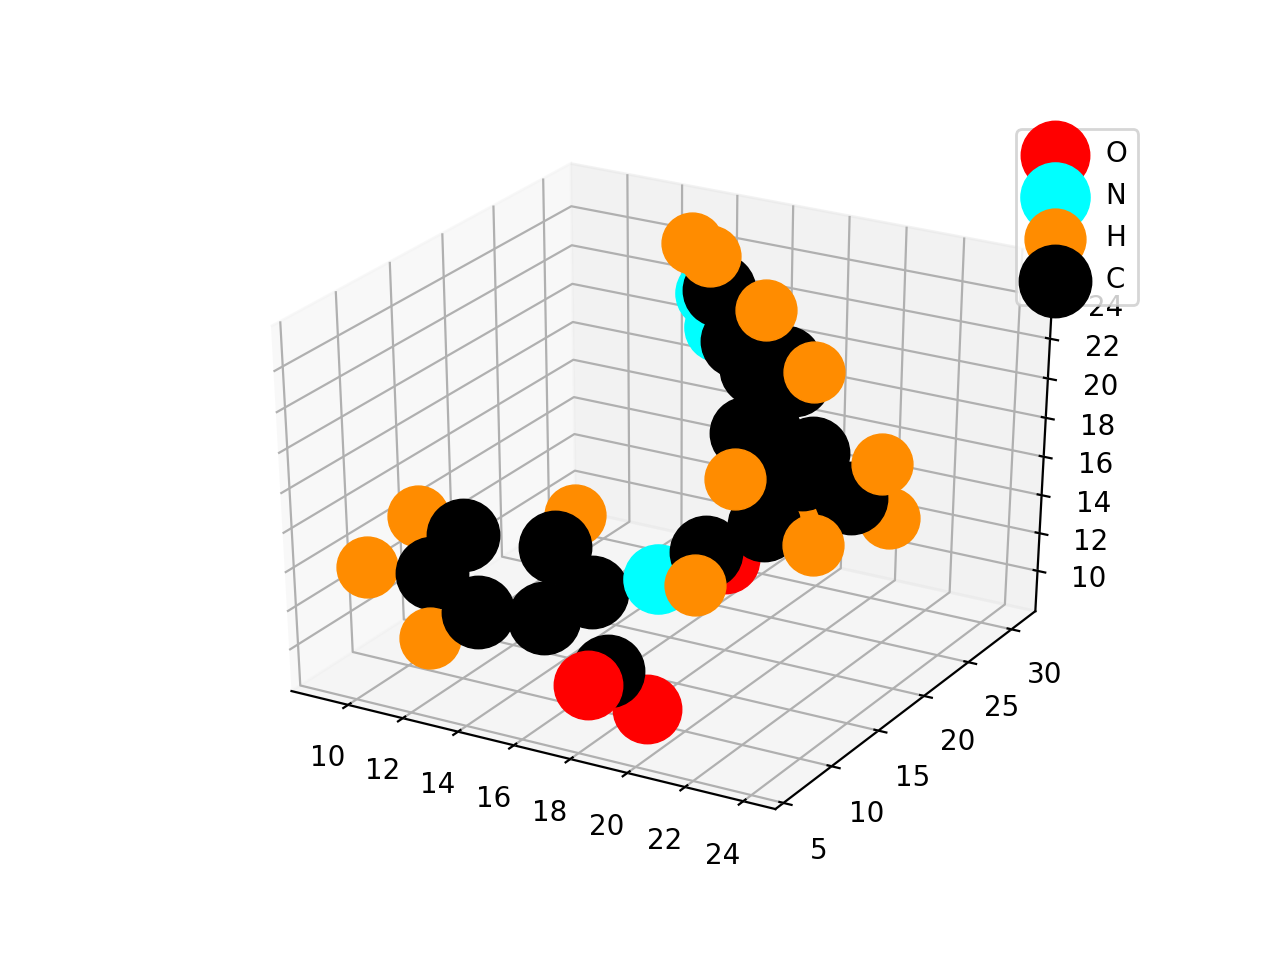

100%|██████████| 43/43 [00:00<00:00, 648.01it/s]


In [42]:
%matplotlib notebook
plot_3d(labels_core, labels, pos_core, positions, size, vocabulary_elements, centers=True)

In [43]:
params_test = {'dim': (x,y,z),
          'batch_size': 10,
          'n_classes': 2,
          'n_channels': l,
          'shuffle': False,
          'tofit': False}

In [44]:
test_generator = DataGenerator([nsample], labels=y_train, X=X, **params_test)

In [45]:
pred_baseline = loaded_model.predict_generator(test_generator)[0]
true_label = y_train[nsample]
label = np.argmax(pred_baseline)
true_label[label], pred_baseline[label]

1 1


(1.0, 0.99009866)

In [46]:
X0.shape

(40, 40, 40, 10)

In [47]:
def rescale_vector(x):
    tmax = 100
    tmin = -100
    rmax = max(x)
    rmin = min(x)
    return np.array([((m - rmin)/(rmax - rmin))*(tmax-tmin) + tmin for m in x])

In [48]:
pos_ligand = np.load(os.path.join(folder_topass, "pixels_imp_{}_{}.npy".format(nsample, resolution)))

In [50]:
pos_ligand.shape, positions.shape

((1784, 4), (2418, 3))

In [110]:
fig = px.scatter_3d(x=pos_ligand[:,0], y=pos_ligand[:,1], z=pos_ligand[:,2],
              color=rescaled)
fig.show()

<IPython.core.display.Javascript object>


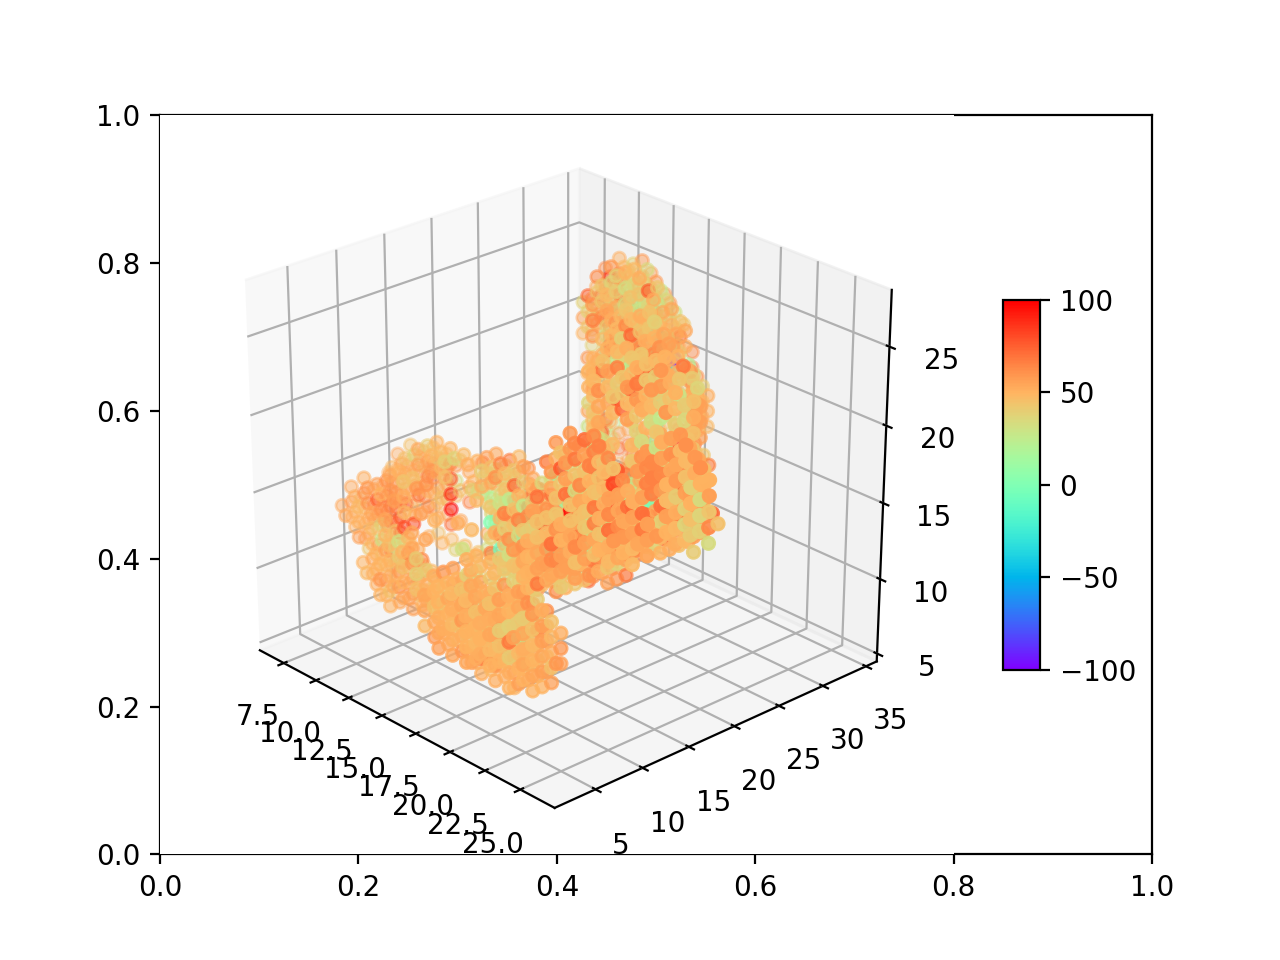

/opt/anaconda2/envs/modtox/lib/python3.7/site-packages/ipykernel_launcher.py:3: UserWarning:

Requested projection is different from current axis projection, creating new axis with requested projection.



In [111]:
%matplotlib notebook
fig, ax = plt.subplots()
ax = fig.gca(projection='3d')
rescaled = rescale_vector(pos_ligand[:,3])
surf = ax.scatter(pos_ligand[:,0], pos_ligand[:,1], pos_ligand[:,2], c=rescaled, cmap='rainbow', marker='o')
fig.colorbar(surf, shrink=0.5, aspect=10)
plt.show()

In [15]:
####

In [ ]:
x, y, z = np.unravel_index(np.argsort(importance_pixel, axis=None), importance_pixel.shape)

In [ ]:

nsamples = len(X)
x,y,z,l = X[0].shape
blank_pixel = np.zeros(l)

importance_pixel = np.zeros((x,y,z))

for coordx in tqdm(range(x)):
    for coordy in range(y):
        for coordz in range(z):
            new_X_train = X[nsample].todense()
            if 1 in new_X_train[coordx,coordy,coordz]:
                new_X_train[coordx, coordy, coordz] = blank_pixel
                new_X_sparse = [sparse.COO(new_X_train)]
                test_generator = DataGenerator([0], labels=y_train, X=new_X_sparse, **params_test)
                pred =  loaded_model.predict_generator(test_generator)[0]
                if true_label[label] == 1:
                    importance_single_pixel = pred[1] - pred_baseline[1] 
                else:
                    importance_single_pixel = pred_baseline[1] - pred[1] 
            else:
                importance_single_pixel=0
            importance_pixel[coordx,coordy,coordz] = importance_single_pixel


In [ ]:
idx_imp = 2
idx = [x[-idx_imp], y[-idx_imp], z[-idx_imp]]
importance = importance_pixel[x[-idx_imp], y[-idx_imp], z[-idx_imp]]
print(importance, idx, rear_bck_pixel + np.array([+x[-idx_imp]+1,-y[-idx_imp],-z[-idx_imp]]))

In [ ]:
def visualize(result, y_train, nsample):
    npixel = 20
    heat_map_grids = []
    heat_elements_grids = []
    for plane in range(20):
        sample = X_train[nsample][:,:,plane].copy()
        explanation_grid = np.zeros((npixel, npixel)).copy()
        explanation_str_grid = np.empty((npixel, npixel), dtype="<U5")
        x, y, channels = sample.shape


        key_list = list(vocabulary_elements.keys()) 
        val_list = list(vocabulary_elements.values())

        for i in range(x):
            for j in range(y):
                for k in range(channels):
                    channel = sample[i, j, k]
                    if channel != 0:
                        element = key_list[val_list.index(k)]
                        explanation_grid[i, j] += 1
                        explanation_str_grid[i, j] += element
        heat_map_grids.append(explanation_grid)
        heat_elements_grids.append(explanation_str_grid)
    
    final_grid_elements = np.empty((npixel, npixel), dtype="<U5")
    final_grid = np.zeros((npixel, npixel)).copy()
    for grid_el, grid in zip(heat_elements_grids, heat_map_grids):
        final_grid_elements = np.core.defchararray.add(final_grid_elements, grid_el)
        final_grid += grid
    
    print(final_grid_elements)
    
    print("Class", np.argmax(y_train[nsample]), "Prob", y_train[nsample])
    data = final_grid
    plt.matshow(data)
    plt.show()

In [ ]:
vocabulary_elements

In [ ]:
X_train[nsample][x[-idx_imp], y[-idx_imp], z[-idx_imp]]

# Visualize Filters

As many dimensions as filter X channel --> Too many

In [ ]:
model.summary()

In [ ]:
convolutionals_layers = []
# summarize filter shapes
for layer in model.layers:
    # check for convolutional layer
    if 'conv' not in layer.name:
        continue
    else:
        convolutionals_layers.append(layer)
convolutionals_layers

In [ ]:
for layer in convolutionals_layers:
    # get filter weights
    filters, biases = layer.get_weights()
    print(layer.name, filters.shape)

In [ ]:
# cannot easily visualize filters lower down
from keras.applications.vgg16 import VGG16
from matplotlib import pyplot
# load the model
# retrieve weights from the second hidden layer
filters, biases = convolutionals_layers[1].get_weights()
# normalize filter values to 0-1 so we can visualize them
f_min, f_max = filters.min(), filters.max()
filters = (filters - f_min) / (f_max - f_min)
# plot first few filters
n_filters, ix = 2, 1
for i in range(n_filters):
    # get the filter
    f = filters[:, :, :, i]
    # plot each channel separately
    for j in range(15):
        # specify subplot and turn of axis
        ax = pyplot.subplot(n_filters, 15, ix)
        ax.set_xticks([])
        ax.set_yticks([])
        # plot filter channel in grayscale
        final_filter = np.zeros((f.shape[0], f.shape[1], f.shape[3]))
        for i in range(f.shape[2]):
            final_filter += f[:,:,i, :]
        pyplot.imshow(final_filter[:, :, j], cmap='gray')
        ix += 1
# show the figure
pyplot.show()

# Feature Map

In [ ]:
# redefine model to output right after the first hidden layer
ixs = [2, 5, 8]
outputs = [model.layers[i].output for i in ixs]
model1 = Model(inputs=model.inputs, outputs=outputs)
samples = X_train[0]
feature_maps = model1.predict(samples.reshape(1, 20, 20, 20, 9))
# plot the output from each block




for fmap in feature_maps:
    # plot all 64 maps in an 8x8 squares
    fig = plt.figure(figsize=(x, y))
    ix = 1
    for _ in range(15):
        # specify subplot and turn of axis
        ax = pyplot.subplot(8, 8, ix)
        ax.set_xticks([])
        ax.set_yticks([])
        # plot filter channel in gray scale
        final_map = np.zeros((fmap.shape[1], fmap.shape[2], fmap.shape[4]))
        for i in range(fmap.shape[3]):
            final_map += fmap[0, :,:, i, :]
        pyplot.imshow(final_map[:, :, ix-1], cmap='gray')
        ix += 1
# show the figure
    fig.show()

# CMAP

https://github.com/nickbiso/Keras-Class-Activation-Map/blob/master/Class%20Activation%20Map(CAM).ipynb

In [ ]:
from keras import backend as K

nsample=0

print(nsample)
#Prediction
argmax = np.argmax(preds[nsample])
#Probability
probability = preds[nsample][argmax]
#Output
output = model.output[:, argmax]
#Las convulutional layer
last_conv_layer = model.get_layer('conv3d_2')
#Intensity of the channels
grads = K.gradients(output, last_conv_layer.output)[0]
pooled_grads = K.mean(grads, axis=(0, 1, 2, 3))
iterate = K.function([model.input], [pooled_grads, last_conv_layer.output[0]])
pooled_grads_value, conv_layer_output_value = iterate([X_train])

In [ ]:
#For each channel we multiply for its intensity
for i in range(conv_layer_output_value.shape[2]):
    conv_layer_output_value[:, :, i] *= pooled_grads_value[i]

In [ ]:
visualize(X_train, y_train, 0)

In [ ]:
print("Class", argmax, "Prob", probability)
data = final_grid
plt.matshow(data)
plt.show()

In [ ]:
output = np.zeros(conv_layer_output_value[:,:,1].shape)
for i in range(conv_layer_output_value.shape[2]):
    output += conv_layer_output_value[:,:,i]
output

In [ ]:
import cv2
print("Predicted Class", argmax, "Real Class", Y[0], "Prob", probability)
heatmap = abs(np.mean(output, axis=-1))
#heatmap = np.maximum(heatmap, 0)
#heatmap /= np.max(heatmap)
heatmap = cv2.resize(heatmap, (20, 20), interpolation = cv2.INTER_CUBIC)
plt.matshow(heatmap)
plt.colorbar()
plt.show()



In [ ]:
#heatmap = np.uint8(255 * heatmap)
#heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
#data = cv2.applyColorMap(data, cv2.COLORMAP_BONE)
heatmap_norm = np.maximum(heatmap, 0)
heatmap_norm /= np.max(heatmap_norm)
superimposed_img =  7*heatmap_norm +  data
plt.imshow(superimposed_img)


In [ ]:
gap_weights = model.layers[-1].get_weights()[0]
gap_weights.shape

In [ ]:
cam_model  = Model(inputs=model.input,outputs=(model.layers[-3].output,model.layers[-1].output))

In [ ]:
cam_model.summary()

In [ ]:
features,results = cam_model.predict(X_train)
features.shape, results.shape

In [ ]:
results

In [ ]:
for i, result in enumerate(results):
    if np.argmax(result) == 1:
        print(i)

In [ ]:
for idx in range(2):
    features_for_one_img = features[idx,:,:,:]
    #height_roomout = X_train.shape[1]/features_for_one_img.shape[0]
    #width_roomout  = X_train.shape[2]/features_for_one_img.shape[1]
    #print(height_roomout,width_roomout)
 
    #cam_features = sp.ndimage.zoom(features_for_one_img, (height_roomout, width_roomout, 1), order=2)
    #print(cam_features.shape)
    pred = np.argmax(results[idx])
    cam_features = features_for_one_img
    
    
    plt.figure(facecolor='white')
    cam_weights = gap_weights[:,pred]
    cam_output  = np.dot(cam_features,cam_weights)
    #print(features_for_one_img.shape)

    buf = 'Predicted Class = ' +str( pred )+ ', Probability = ' + str(results[idx][pred])

    

    #plt.imshow(np.squeeze(X_train[idx],-1), alpha=0.5)

    for i in range(6):
        plt.figure(facecolor='white')
        new_buf  = buf + "plane {}".format(i)
        plt.xlabel(new_buf)
        plt.imshow(cam_output[:,:,i], cmap='jet', alpha=0.5)


In [ ]:
print(explanation_grid)

In [ ]:
sample

In [ ]:
vocabulary_elements